In [24]:
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers import Dense

import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as bs4
import matplotlib.pyplot as plt

**Improvements**

1. More models
2. Try with TFIDF
3. Look at the Kaggle notebooks and take inspo

# Cleaning
Only run when adding new stuff to cleaner, otherwise use the CSV in the next section

In [ ]:
# reading original
original = pd.read_csv('labeledTrainData.tsv', sep="\t")

In [ ]:
stops = stopwords.words("english")
porter = PorterStemmer()

nr_reviews = original['review'].size

def clean_text(text, index):
    text = bs4(text).get_text()
    words = word_tokenize(text)
    words_no_punc = [word.lower() for word in words if word.isalpha()]
    no_stop = [word for word in words_no_punc if word not in stops]
    stems = [porter.stem(word) for word in no_stop]
    clean = ' '.join(stems)

    index = index + 1
    if ((index)%500 == 0):
        print('\r', end='')
        progress = int(100*index/nr_reviews)
        print(f'{progress}%', end=' ')

    return clean

original["review_clean"] = original.apply(lambda row: clean_text(row['review'], row.name), axis=1)
original.to_csv('train_clean.csv', index=False)

# Train, test and Bag of Words

In [2]:
df = pd.read_csv('train_clean.csv', usecols=["sentiment", "review", "review_clean"])

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df['review_clean'], df['sentiment'], test_size=0.2)

In [9]:
# Bag of Words
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Logistic regression
~87% accuracy

In [10]:
# Fitting
logreg = LogisticRegression(max_iter=1000, verbose=2)

logreg.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s finished


LogisticRegression(max_iter=1000, verbose=2)

In [11]:
pred_logreg = logreg.predict(X_test)
confusion_matrix(pred_logreg, y_test)

array([[2170,  311],
       [ 348, 2171]])

In [12]:
print(classification_report(pred_logreg, y_test))

              precision    recall  f1-score   support

           0       0.86      0.87      0.87      2481
           1       0.87      0.86      0.87      2519

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000



# KNN
~63% accuracy

In [ ]:
# getting optimal nr of neighbors (takes ~2 mins)
knn_grid = GridSearchCV(
    estimator=KNeighborsClassifier(), 
    param_grid={'n_neighbors': np.arange(3,11)}, # surely not less than 3, 11 as max due to time consumption
    verbose=2,
    cv=3
)
knn_grid.fit(X_train, y_train)
optimal_neighbors = knn_grid.best_params_['n_neighbors']
optimal_neighbors # Will return 9

In [ ]:
knn = KNeighborsClassifier(n_neighbors=9) # optimal_neighbors w/o having to run it
knn.fit(X_train, y_train)

In [ ]:
pred_knn = knn.predict(X_test)
confusion_matrix(pred_knn, y_test)

In [ ]:
print(classification_report(pred_knn, y_test))

# Naive Bayes
~65% accuracy

In [ ]:
nb = GaussianNB()

nb.fit(X_train.toarray(), y_train)

In [ ]:
pred_nb = nb.predict(X_test.toarray())
confusion_matrix(pred_nb, y_test)

In [ ]:
print(classification_report(pred_nb, y_test))

# Random Forest
~85% accuracy

In [14]:
forest = RandomForestClassifier(max_depth=50, n_estimators=100)

forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=50)

In [15]:
pred_forest = forest.predict(X_test)
confusion_matrix(pred_forest, y_test)

array([[2103,  321],
       [ 415, 2161]])

In [16]:
print(classification_report(pred_forest, y_test))

              precision    recall  f1-score   support

           0       0.84      0.87      0.85      2424
           1       0.87      0.84      0.85      2576

    accuracy                           0.85      5000
   macro avg       0.85      0.85      0.85      5000
weighted avg       0.85      0.85      0.85      5000



# ANN
~87% accuracy

In [ ]:
ann = Sequential()
ann.add(Dense(10, activation = 'relu'))
ann.add(Dense(10, activation = 'relu'))
ann.add(Dense(1, activation = 'sigmoid'))
ann.compile(optimizer = 'Adam', loss ='binary_crossentropy', metrics = ['accuracy'])
ann.fit(X_train.toarray(), y_train, batch_size=32, epochs=5, verbose=2)

In [ ]:
pred_ann = ann.predict(X_test) > 0.5
confusion_matrix(pred_ann, y_test)

In [ ]:
print(classification_report(pred_ann, y_test))

# SVM

In [ ]:
svm = SVC(kernel="linear")

svm.fit(X_train, y_train) # really sloooow haven't even run it cause it takes too much time

# TF-IDF
Instead of Bag of Words

In [7]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [17]:
# Testing with logreg

logreg = LogisticRegression(max_iter=1000, verbose=2)

logreg.fit(X_train_tfidf,y_train)
pred_logreg_tfidf = logreg.predict(X_test_tfidf)
print(classification_report(pred_logreg_tfidf, y_test))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
              precision    recall  f1-score   support

           0       0.87      0.90      0.89      2441
           1       0.90      0.87      0.89      2559

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s finished


# Exploration
To find more potential differences btwn groups that can be inserted into the model

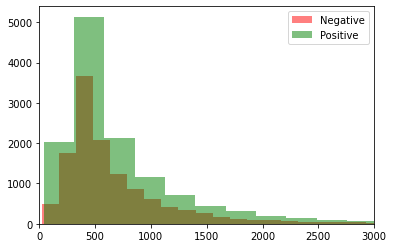

In [46]:
df['length'] = df['review_clean'].apply(lambda x: len(x))

length_0 = df.loc[df.sentiment==0, 'length']
length_1 = df.loc[df.sentiment==1, 'length']
kwargs = dict(alpha=0.5, bins=30)
plt.hist(length_0, **kwargs, color='r', label='Negative')
plt.hist(length_1, **kwargs, color='g', label='Positive')
plt.xlim(0,3000)
plt.legend();